In [ ]:
#importing required libraries and packages

import pandas as pd
import numpy as np
import numpy.random as nr
import matplotlib
import matplotlib.pyplot as plt
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
import sklearn.model_selection as ms
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from pathlib import Path

In [ ]:
#all helper functions used

def drop_columns(data, *args):

    '''
    function used to drop columns.
    args::
      data:  dataframe to be operated on
      *args: a list of columns to be dropped from the dataframe

    return: returns a dataframe with the columns dropped
    '''

    columns = []
    for _ in args:
        columns.append(_)

    data = data.drop(columns, axis=1)

    return data

def process(data):

    '''
    function to process dataframe by replacing missing, infinity values with -999

    args::
      data:  dataframe to be operated on

    returns dataframe with replaced values
    '''

    cols = list(data.columns)
    for _ in cols:

        data[_] = np.where(data[_] == np.inf, -999, data[_])
        data[_] = np.where(data[_] == np.nan, -999, data[_])
        data[_] = np.where(data[_] == -np.inf, -999, data[_])

    return data

def show_evaluation(pred, true):

  '''

  function to show model performance and evaluation
  args:
    pred: predicted value(a list)
    true: actual values (a list)

  prints the custom metric performance, accuracy and F1 score of predictions

  '''

  print(f'Default score: {score(true.values, pred)}')
  print(f'Accuracy is: {accuracy_score(true, pred)}')
  print(f'F1 is: {f1_score(pred, true.values, average="weighted")}')


#Paulo Bestagini's feature augmentation technique from SEG 2016 ML competition
#Link : https://github.com/seg/2016-ml-contest/tree/master/ispl

# Feature windows concatenation function
def augment_features_window(X, N_neig):

    # Parameters
    N_row = X.shape[0]
    N_feat = X.shape[1]

    # Zero padding
    X = np.vstack((np.zeros((N_neig, N_feat)), X, (np.zeros((N_neig, N_feat)))))

    # Loop over windows
    X_aug = np.zeros((N_row, N_feat*(2*N_neig+1)))
    for r in np.arange(N_row)+N_neig:
        this_row = []
        for c in np.arange(-N_neig,N_neig+1):
            this_row = np.hstack((this_row, X[r+c]))
        X_aug[r-N_neig] = this_row

    return X_aug

# Feature gradient computation function
def augment_features_gradient(X, depth):

    # Compute features gradient
    d_diff = np.diff(depth).reshape((-1, 1))
    d_diff[d_diff==0] = 0.001
    X_diff = np.diff(X, axis=0)
    X_grad = X_diff / d_diff

    # Compensate for last missing value
    X_grad = np.concatenate((X_grad, np.zeros((1, X_grad.shape[1]))))

    return X_grad

# Feature augmentation function
def augment_features(X, well, depth, N_neig=1):

    # Augment features
    X_aug = np.zeros((X.shape[0], X.shape[1]*(N_neig*2+2)))
    for w in np.unique(well):
        w_idx = np.where(well == w)[0]
        X_aug_win = augment_features_window(X[w_idx, :], N_neig)
        X_aug_grad = augment_features_gradient(X[w_idx, :], depth[w_idx])
        X_aug[w_idx, :] = np.concatenate((X_aug_win, X_aug_grad), axis=1)

    # Find padded rows
    padded_rows = np.unique(np.where(X_aug[:, 0:7] == np.zeros((1, 7)))[0])

    return X_aug, padded_rows

def score(y_true, y_pred):

    '''
    custom metric used for evaluation
    args:
      y_true: actual prediction
      y_pred: predictions made
    '''

    S = 0.0
    y_true = y_true.astype(int)
    y_pred = y_pred.astype(int)
    for i in range(0, y_true.shape[0]):
        S -= A[y_true[i], y_pred[i]]
    return S/y_true.shape[0]

In [ ]:
# Define base directory relative to your known home
base_dir = Path("/Users/Engineering User/Desktop/Force_Lith_Classification/Data")

#importing penaltry matrix used for evaluation and train and test files
A = np.load(base_dir / 'penalty_matrix.npy')

train = pd.read_csv(base_dir / 'train.csv', sep=';')

test = pd.read_csv(base_dir / 'hidden_test.csv', sep=';')

In [ ]:
class Model():

    '''
    class to lithology prediction
    '''

    def __init__(self, train, test):

        '''
        takes in the train and test dataframes
        '''

        self.train = train
        self.test = test


    def __call__(self, plot = True):

      return self.fit(plot)

    def preprocess(self, train, test):

        '''
        method to prepare datasets for training and predictions
        accepts both the train and test dataframes as arguments

        returns the prepared train, test datasets along with the
        lithology labels and numbers which is needed for preparing
        the submission file

        '''

        #concatenating both train and test datasets for easier and uniform processing

        ntrain = train.shape[0]
        ntest = test.shape[0]
        target = train.FORCE_2020_LITHOFACIES_LITHOLOGY.copy()
        df = pd.concat((train, test)).reset_index(drop=True)

        #mapping the lithology labels to ordinal values for better modelling

        lithology = train['FORCE_2020_LITHOFACIES_LITHOLOGY']

        lithology_numbers = {30000: 0,
                        65030: 1,
                        65000: 2,
                        80000: 3,
                        74000: 4,
                        70000: 5,
                        70032: 6,
                        88000: 7,
                        86000: 8,
                        99000: 9,
                        90000: 10,
                        93000: 11}

        lithology1 = lithology.map(lithology_numbers)

        #implementing Bestagini's augmentation procedure

        train_well = train.WELL.values
        train_depth = train.DEPTH_MD.values

        test_well = test.WELL.values
        test_depth = test.DEPTH_MD.values
        '''to be continued...
        #this was done here for ease as the datasets would undergo some transformations
        #that would make it uneasy to perform the augmentation technique'''



        print(f'shape of concatenated dataframe before dropping columns {df.shape}')

        cols = ['FORCE_2020_LITHOFACIES_CONFIDENCE', 'SGR', 'DTS', 'RXO', 'ROPA'] #columns to be dropped
        df = drop_columns(df, *cols)
        print(f'shape of dataframe after dropping columns {df.shape}')
        print(f'{cols} were dropped')

        #Label encoding the GROUP, FORMATION and WELLS features as these improved the performance of the models on validations

        df['GROUP_encoded'] = df['GROUP'].astype('category')
        df['GROUP_encoded'] = df['GROUP_encoded'].cat.codes
        df['FORMATION_encoded'] = df['FORMATION'].astype('category')
        df['FORMATION_encoded'] = df['FORMATION_encoded'].cat.codes
        df['WELL_encoded'] = df['WELL'].astype('category')
        df['WELL_encoded'] = df['WELL_encoded'].cat.codes
        print(f'shape of dataframe after label encoding columns {df.shape}')


        #FURTHER PREPRATION TO SPLIT DATAFRAME INTO TRAIN AND TEST DATASETS AFTER PREPRATION
        print(f'Splitting concatenated dataframe into training and test datasets...')
        df = df.drop(['WELL', 'GROUP', 'FORMATION'], axis=1)
        print(df.shape)

        df = df.fillna(-999)
        df = process(df)
        data = df.copy()

        train2 = data[:ntrain].copy()
        train2.drop(['FORCE_2020_LITHOFACIES_LITHOLOGY'], axis=1, inplace=True)

        test2 = data[ntrain:(ntest+ntrain)].copy()
        test2.drop(['FORCE_2020_LITHOFACIES_LITHOLOGY'], axis=1, inplace=True)
        test2 = test2.reset_index(drop=True)

        traindata = train2
        testdata = test2

        print(f'Shape of train and test datasets before augmentation {traindata.shape, testdata.shape}')

        traindata1, padded_rows = augment_features(pd.DataFrame(traindata).values, train_well, train_depth)
        testdata1, padded_rows = augment_features(pd.DataFrame(testdata).values, test_well, test_depth)

        print(f'Shape of train and test datasets after augmentation {traindata1.shape, testdata1.shape}')

        return traindata1, testdata1, lithology1, lithology_numbers


    def fit(self, plot):

      '''
      method to train model and make predictions

      returns the test predictions, trained model, and lithology numbers used for making the submission file
      '''

      traindata1, testdata1, lithology1, lithology_numbers = self.preprocess(self.train, self.test)

      #using a 10-fold stratified cross-validation technique and seting the shuffle parameter to true
      #as this improved the validation performance better

      split = 10
      kf = StratifiedKFold(n_splits=split, shuffle=True)

      open_test = np.zeros((len(testdata1), 12))


      model = RandomForestClassifier(
            n_estimators=100,
            max_depth=10,
            random_state=0,
            n_jobs=-1,
            verbose=1 #min_samples_split =2 , min_samples_leaf=1
      )

      i = 1
      for (train_index, test_index) in kf.split(pd.DataFrame(traindata1), pd.DataFrame(lithology1)):
        X_train, X_test = pd.DataFrame(traindata1).iloc[train_index], pd.DataFrame(traindata1).iloc[test_index]
        Y_train, Y_test = pd.DataFrame(lithology1).iloc[train_index],pd.DataFrame(lithology1).iloc[test_index]

        model.fit(X_train, Y_train)
        prediction = model.predict(X_test)
        print(show_evaluation(prediction, Y_test))

        print(f'-----------------------FOLD {i}---------------------')
        i+=1

        open_test += model.predict_proba(pd.DataFrame(testdata1))

      open_test= pd.DataFrame(open_test/split)

      open_test = np.array(pd.DataFrame(open_test).idxmax(axis=1))

      print('---------------CROSS VALIDATION COMPLETE')
      print('----------------TEST EVALUATION------------------')


      if plot: self.plot_feat_imp(model)
      return open_test, model, lithology_numbers


    def plot_feat_imp(self, model):
        #feat_imp = pd.Series(model.get_feature_importance()).sort_values(ascending=False)
        feat_imp = pd.Series(model.feature_importances_).sort_values(ascending=False)
        plt.figure(figsize=(12,8))
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')

    def make_submission_file(self, filename):

      '''
      method to train model, make prediction and create submission file
      args::
        filename: name to save submission file as (string)
      '''

      self.filename = filename

      prediction, model, lithology_numbers = self.fit(plot=False)

      #path = PWD

      test = pd.read_csv(base_dir /'hidden_test.csv', sep=';')

      category_to_lithology = {y:x for x,y in lithology_numbers.items()}
      test_prediction_for_submission = np.vectorize(category_to_lithology.get)(prediction)
      np.savetxt(path+filename+'.csv', test_prediction_for_submission, header='lithology', fmt='%i')

shape of concatenated dataframe before dropping columns (1292908, 29)
shape of dataframe after dropping columns (1292908, 24)
['FORCE_2020_LITHOFACIES_CONFIDENCE', 'SGR', 'DTS', 'RXO', 'ROPA'] were dropped
shape of dataframe after label encoding columns (1292908, 27)
Splitting concatenated dataframe into training and test datasets...
(1292908, 24)
Shape of train and test datasets before augmentation ((1170511, 23), (122397, 23))
Shape of train and test datasets after augmentation ((1170511, 92), (122397, 92))


C:\Users\Engineering User\AppData\Local\Temp\ipykernel_16216\4288601614.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, Y_train)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.2min finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 100 out of 100 | elapsed:    0.2s finished


Default score: [-0.38280102]
Accuracy is: 0.8564911321463965
F1 is: 0.8692334985489918
None
-----------------------FOLD 1---------------------


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 100 out of 100 | elapsed:    0.3s finished
C:\Users\Engineering User\AppData\Local\Temp\ipykernel_16216\4288601614.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, Y_train)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.3min finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 100 out of 100 | elapsed:    0.2s finished


Default score: [-0.38378677]
Accuracy is: 0.8565240792475075
F1 is: 0.869377520180385
None
-----------------------FOLD 2---------------------


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 100 out of 100 | elapsed:    0.2s finished
C:\Users\Engineering User\AppData\Local\Temp\ipykernel_16216\4288601614.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, Y_train)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.3min finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 100 out of 100 | elapsed:    0.2s finished


Default score: [-0.38620238]
Accuracy is: 0.8551400671502166
F1 is: 0.8680184674202083
None
-----------------------FOLD 3---------------------


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 100 out of 100 | elapsed:    0.3s finished
C:\Users\Engineering User\AppData\Local\Temp\ipykernel_16216\4288601614.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, Y_train)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.3min finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 100 out of 100 | elapsed:    0.3s finished


Default score: [-0.38054246]
Accuracy is: 0.8569256136214128
F1 is: 0.8696032280833315
None
-----------------------FOLD 4---------------------


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 100 out of 100 | elapsed:    0.2s finished
C:\Users\Engineering User\AppData\Local\Temp\ipykernel_16216\4288601614.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, Y_train)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.3min finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 100 out of 100 | elapsed:    0.2s finished


Default score: [-0.3837259]
Accuracy is: 0.8563361269873816
F1 is: 0.8691473477578541
None
-----------------------FOLD 5---------------------


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 100 out of 100 | elapsed:    0.3s finished
C:\Users\Engineering User\AppData\Local\Temp\ipykernel_16216\4288601614.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, Y_train)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.3min finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 100 out of 100 | elapsed:    0.3s finished


Default score: [-0.38499351]
Accuracy is: 0.8557722702070037
F1 is: 0.8689582081861223
None
-----------------------FOLD 6---------------------


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 100 out of 100 | elapsed:    0.2s finished
C:\Users\Engineering User\AppData\Local\Temp\ipykernel_16216\4288601614.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, Y_train)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.4min finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 100 out of 100 | elapsed:    0.3s finished


Default score: [-0.37944358]
Accuracy is: 0.8577543122228772
F1 is: 0.8701520145246867
None
-----------------------FOLD 7---------------------


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 100 out of 100 | elapsed:    0.3s finished
C:\Users\Engineering User\AppData\Local\Temp\ipykernel_16216\4288601614.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, Y_train)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.4min finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 100 out of 100 | elapsed:    0.2s finished


Default score: [-0.3878192]
Accuracy is: 0.8549606581746418
F1 is: 0.868275571584276
None
-----------------------FOLD 8---------------------


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 100 out of 100 | elapsed:    0.2s finished
C:\Users\Engineering User\AppData\Local\Temp\ipykernel_16216\4288601614.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, Y_train)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.4min finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 100 out of 100 | elapsed:    0.2s finished


Default score: [-0.38101661]
Accuracy is: 0.8567547479303893
F1 is: 0.8695959129510894
None
-----------------------FOLD 9---------------------


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 100 out of 100 | elapsed:    0.3s finished
C:\Users\Engineering User\AppData\Local\Temp\ipykernel_16216\4288601614.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, Y_train)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.4min finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 100 out of 100 | elapsed:    0.3s finished


Default score: [-0.38607957]
Accuracy is: 0.8555074283859172
F1 is: 0.8683579686502367
None
-----------------------FOLD 10---------------------


[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 100 out of 100 | elapsed:    0.2s finished


---------------CROSS VALIDATION COMPLETE
----------------TEST EVALUATION------------------


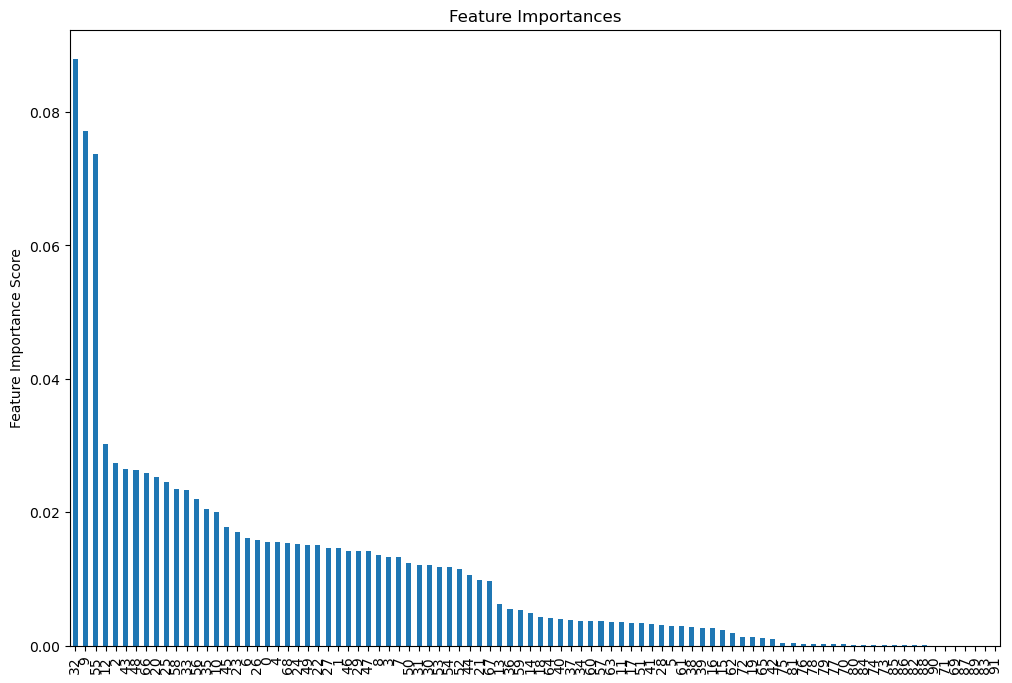

In [ ]:
#To train model and make prediction

func_= Model(train, test)
prediction, model, redundant = func_()

In [ ]:
prediction

array([2, 2, 2, ..., 2, 2, 2], dtype=int64)

In [ ]:
len(prediction)

122397

In [ ]:
from pathlib import Path
import numpy as np

lithology_numbers = {30000: 0,
                65030: 1,
                65000: 2,
                80000: 3,
                74000: 4,
                70000: 5,
                70032: 6,
                88000: 7,
                86000: 8,
                99000: 9,
                90000: 10,
                93000: 11}
# Set base directory (adjust if needed)
base_dir_N = Path("/Users/Engineering User/Desktop/Force_Lith_Classification/Notebook")

# Map predicted class numbers back to original lithology codes
category_to_lithology = {y: x for x, y in lithology_numbers.items()}
test_prediction_for_submission = np.vectorize(category_to_lithology.get)(prediction)

# Define full path to save file
filename = "Olawale_Predictions_RF"
output_file = base_dir_N / f"{filename}.csv"

# Save the prediction file
np.savetxt(output_file, test_prediction_for_submission, header='lithology', fmt='%i', comments='')


# Just Run Separate: Comparing with actual test predictions

In [ ]:
# Define base directory relative to your known home
base_dir = Path("/Users/Engineering User/Desktop/Force_Lith_Classification/Data")

test = pd.read_csv(base_dir / 'hidden_test.csv', sep=';')

In [ ]:
test.columns

Index(['WELL', 'DEPTH_MD', 'X_LOC', 'Y_LOC', 'Z_LOC', 'GROUP', 'FORMATION',
       'CALI', 'RSHA', 'RMED', 'RDEP', 'RHOB', 'GR', 'SGR', 'NPHI', 'PEF',
       'DTC', 'SP', 'BS', 'ROP', 'DTS', 'DCAL', 'DRHO', 'MUDWEIGHT', 'RMIC',
       'ROPA', 'RXO', 'FORCE_2020_LITHOFACIES_LITHOLOGY',
       'FORCE_2020_LITHOFACIES_CONFIDENCE'],
      dtype='object')

In [ ]:
actual_class = test['FORCE_2020_LITHOFACIES_LITHOLOGY'].to_numpy()

In [ ]:
# Define base directory relative to your known home
base_dir_predict = Path("/Users/Engineering User/Desktop/Force_Lith_Classification/Notebook")

In [ ]:
pred_df = pd.read_csv(base_dir_predict / 'Olawale_Predictions_RF.csv', sep=';')
pred_df

,lithology
0,65000
1,65000
2,65000
3,65000
4,65000
...,...
122392,65000
122393,65000
122394,65000
122395,65000


In [ ]:
test_prediction_for_submission = pred_df['lithology'].to_numpy()

In [ ]:
test_prediction_for_submission

array([65000, 65000, 65000, ..., 65000, 65000, 65000], dtype=int64)

In [ ]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(actual_class, test_prediction_for_submission)
print(f"Accuracy: {acc:.4f}")


Accuracy: 0.7737


In [ ]:
from sklearn.metrics import f1_score

f1 = f1_score(actual_class, test_prediction_for_submission, average='weighted')
print(f"Weighted F1 Score: {f1:.4f}")


Weighted F1 Score: 0.7296


In [ ]:
# Example: test_prediction_for_submission = np.array([...])
unique_values, counts = np.unique(test_prediction_for_submission, return_counts=True)

# Display results
for val, count in zip(unique_values, counts):
    print(f"Value {val}: {count} times")

Value 30000: 12577 times
Value 65000: 88691 times
Value 65030: 3716 times
Value 70000: 10179 times
Value 70032: 320 times
Value 80000: 479 times
Value 86000: 451 times
Value 88000: 5814 times
Value 90000: 101 times
Value 99000: 69 times


In [ ]:
# Example: test_prediction_for_submission = np.array([...])
unique_values, counts = np.unique(actual_class, return_counts=True)

# Display results
for val, count in zip(unique_values, counts):
    print(f"Value {val}: {count} times")

Value 30000: 14045 times
Value 65000: 71827 times
Value 65030: 12283 times
Value 70000: 8374 times
Value 70032: 2905 times
Value 74000: 287 times
Value 80000: 4396 times
Value 86000: 597 times
Value 88000: 6498 times
Value 90000: 244 times
Value 99000: 941 times


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Original label mapping (in desired order)
lithology_keys = {
    30000: 'Sandstone',
    65030: 'Sandstone/Shale',
    65000: 'Shale',
    80000: 'Marl',
    74000: 'Dolomite',
    70000: 'Limestone',
    70032: 'Chalk',
    88000: 'Halite',
    86000: 'Anhydrite',
    99000: 'Tuff',
    90000: 'Coals',
    93000: 'Basement'
}

# Convert actual and predicted to string labels using the mapping
actual_labels = np.vectorize(lithology_keys.get)(actual_class)
predicted_labels = np.vectorize(lithology_keys.get)(test_prediction_for_submission)


In [ ]:
# Example: test_prediction_for_submission = np.array([...])
unique_values, counts = np.unique(predicted_labels, return_counts=True)

# Display results
for val, count in zip(unique_values, counts):
    print(f"Value {val}: {count} times")

Value Anhydrite: 451 times
Value Chalk: 320 times
Value Coals: 101 times
Value Halite: 5814 times
Value Limestone: 10179 times
Value Marl: 479 times
Value Sandstone: 12577 times
Value Sandstone/Shale: 3716 times
Value Shale: 88691 times
Value Tuff: 69 times


In [ ]:
# Example: test_prediction_for_submission = np.array([...])
unique_values, counts = np.unique(actual_labels, return_counts=True)

# Display results
for val, count in zip(unique_values, counts):
    print(f"Value {val}: {count} times")

Value Anhydrite: 597 times
Value Chalk: 2905 times
Value Coals: 244 times
Value Dolomite: 287 times
Value Halite: 6498 times
Value Limestone: 8374 times
Value Marl: 4396 times
Value Sandstone: 14045 times
Value Sandstone/Shale: 12283 times
Value Shale: 71827 times
Value Tuff: 941 times


In [ ]:
from sklearn.metrics import confusion_matrix

# Example arrays
actual = actual_class
predicted = test_prediction_for_submission

# Construct confusion matrix
cm = confusion_matrix(actual, predicted)

print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[ 9445  3444   682   474     0     0     0     0     0     0     0]
 [  385 71035   304    94     0     0     1     4     0     4     0]
 [ 1429  8297  2473    12     0     0    10     0     0     2    60]
 [  818  1968    32  5158   312     0    80     0     0     0     6]
 [  338     0     0  2559     8     0     0     0     0     0     0]
 [    8   161     0     5     0     0     0   113     0     0     0]
 [   28  2747   218  1015     0     0   388     0     0     0     0]
 [   19    12     0   191     0     0     0   328    47     0     0]
 [   12    42     0   671     0     0     0     6  5767     0     0]
 [   29   113     7     0     0     0     0     0     0    95     0]
 [   66   872     0     0     0     0     0     0     0     0     3]]


In [ ]:
import numpy as np

unique, counts = np.unique(actual_class, return_counts=True)
class_distribution = dict(zip(unique, counts))

for lith, count in class_distribution.items():
    print(f"Lithology {lith}: {count} samples")


Lithology 30000: 14045 samples
Lithology 65000: 71827 samples
Lithology 65030: 12283 samples
Lithology 70000: 8374 samples
Lithology 70032: 2905 samples
Lithology 74000: 287 samples
Lithology 80000: 4396 samples
Lithology 86000: 597 samples
Lithology 88000: 6498 samples
Lithology 90000: 244 samples
Lithology 99000: 941 samples


In [ ]:
import numpy as np

unique, counts = np.unique(test_prediction_for_submission, return_counts=True)
class_distribution = dict(zip(unique, counts))

for lith, count in class_distribution.items():
    print(f"Lithology {lith}: {count} samples")


Lithology 30000: 12577 samples
Lithology 65000: 88691 samples
Lithology 65030: 3716 samples
Lithology 70000: 10179 samples
Lithology 70032: 320 samples
Lithology 80000: 479 samples
Lithology 86000: 451 samples
Lithology 88000: 5814 samples
Lithology 90000: 101 samples
Lithology 99000: 69 samples


In [ ]:

# Ensure actual and predicted labels are string-mapped
actual_labels = np.vectorize(lithology_keys.get)(actual_class)
predicted_labels = np.vectorize(lithology_keys.get)(test_prediction_for_submission)

# Keep label order
ordered_labels = list(lithology_keys.values())

# Generate confusion matrix
cm = confusion_matrix(actual_labels, predicted_labels, labels=ordered_labels)

# Convert to DataFrame for clean display
df_cm = pd.DataFrame(cm, index=ordered_labels, columns=ordered_labels)

# Display
print("Confusion Matrix (Raw Counts):")
df_cm

Confusion Matrix (Raw Counts):


,Sandstone,Sandstone/Shale,Shale,Marl,Dolomite,Limestone,Chalk,Halite,Anhydrite,Tuff,Coals,Basement
Sandstone,9445,682,3444,0,0,474,0,0,0,0,0,0
Sandstone/Shale,1429,2473,8297,10,0,12,0,0,0,60,2,0
Shale,385,304,71035,1,0,94,0,0,4,0,4,0
Marl,28,218,2747,388,0,1015,0,0,0,0,0,0
Dolomite,8,0,161,0,0,5,0,0,113,0,0,0
Limestone,818,32,1968,80,0,5158,312,0,0,6,0,0
Chalk,338,0,0,0,0,2559,8,0,0,0,0,0
Halite,12,0,42,0,0,671,0,5767,6,0,0,0
Anhydrite,19,0,12,0,0,191,0,47,328,0,0,0
Tuff,66,0,872,0,0,0,0,0,0,3,0,0


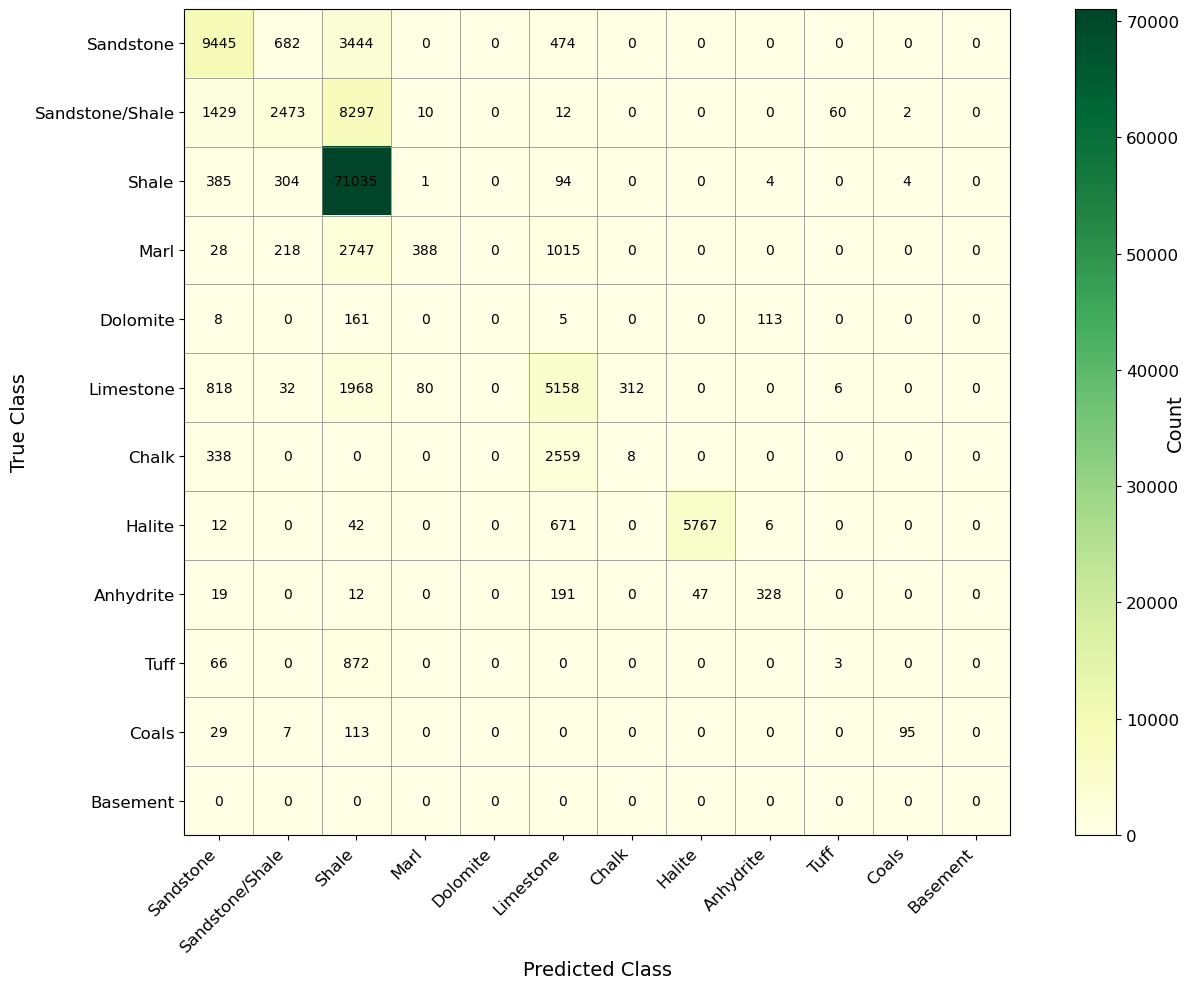

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data to plot
data = df_cm.values
row_labels = df_cm.index.tolist()
col_labels = df_cm.columns.tolist()

fig, ax = plt.subplots(figsize=(14, 10))
cmap = plt.cm.YlGn  # Use the same colormap
im = ax.imshow(data, cmap=cmap)

# Add colorbar (gradient legend)
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Count", rotation=90, va="bottom", fontsize=14)
cbar.ax.tick_params(labelsize=12)

# Show ticks and labels
ax.set_xticks(np.arange(len(col_labels)))
ax.set_yticks(np.arange(len(row_labels)))
ax.set_xticklabels(col_labels, rotation=45, ha='right', fontsize=12)
ax.set_yticklabels(row_labels, fontsize=12)

# Gridlines
ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
ax.grid(which="minor", color='gray', linestyle='-', linewidth=0.5)
ax.tick_params(which="minor", bottom=False, left=False)

# Annotate cells with counts
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        ax.text(j, i, data[i, j], ha="center", va="center", color="black", fontsize=10)

# Titles and labels
#ax.set_title("Confusion Matrix of Random Forest with Data Augmentation", fontsize=16, pad=20)
ax.set_xlabel("Predicted Class", fontsize=14)
ax.set_ylabel("True Class", fontsize=14)
plt.tight_layout()
plt.savefig("confusion_matrix_RF_augmented.pdf", format="pdf", bbox_inches="tight")

plt.show()


In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Map numeric predictions/actuals to strings
actual_labels = np.vectorize(lithology_keys.get)(actual_class)
predicted_labels = np.vectorize(lithology_keys.get)(test_prediction_for_submission)

# Ensure consistent label order
ordered_labels = list(lithology_keys.values())

# Generate report
report = classification_report(actual_labels, predicted_labels, labels=ordered_labels, zero_division=0)

# Print
print("Classification Report:\n")
print(report)


Classification Report:

                 precision    recall  f1-score   support

      Sandstone       0.75      0.67      0.71     14045
Sandstone/Shale       0.67      0.20      0.31     12283
          Shale       0.80      0.99      0.89     71827
           Marl       0.81      0.09      0.16      4396
       Dolomite       0.00      0.00      0.00       287
      Limestone       0.51      0.62      0.56      8374
          Chalk       0.03      0.00      0.00      2905
         Halite       0.99      0.89      0.94      6498
      Anhydrite       0.73      0.55      0.63       597
           Tuff       0.04      0.00      0.01       941
          Coals       0.94      0.39      0.55       244
       Basement       0.00      0.00      0.00         0

      micro avg       0.77      0.77      0.77    122397
      macro avg       0.52      0.37      0.40    122397
   weighted avg       0.75      0.77      0.73    122397



In [ ]:
from sklearn.metrics import accuracy_score

# Assuming you have your true and predicted values
accuracy = accuracy_score(actual_labels, predicted_labels)

print(f"Accuracy: {accuracy:.4f}")


Accuracy: 0.7737


# Final Scoring FORCE METRIC

In [ ]:
def score(y_true, y_pred):

    '''
    custom metric used for evaluation
    args:
      y_true: actual prediction
      y_pred: predictions made
    '''

    S = 0.0
    y_true = y_true.astype(int)
    y_pred = y_pred.astype(int)
    for i in range(0, y_true.shape[0]):
        S -= A[y_true[i], y_pred[i]]
    return S/y_true.shape[0]

In [ ]:
lithology_numbers = {
    30000: 0,
    65030: 1,
    65000: 2,
    80000: 3,
    74000: 4,
    70000: 5,
    70032: 6,
    88000: 7,
    86000: 8,
    99000: 9,
    90000: 10,
    93000: 11
}
# Map using vectorized approach
y_true = np.vectorize(lithology_numbers.get)(actual)
y_true

array([2, 2, 2, ..., 2, 2, 2])

In [ ]:
custom_score = score(y_true, prediction)
custom_score

NameError: name 'prediction' is not defined